In [1]:
# general
import ast
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pytimeparse.timeparse import timeparse
# sklearn_crfsuite
from sklearn_crfsuite import metrics

# bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

sns.set()

In [62]:
def plot_accuracy_distribution(control_group, test_group, test_group_name, bins=30):
    plt.figure(figsize=(10, 6))
    bins = np.linspace(
        df_user_error['f1'].min(),
        df_user_error['f1'].max(),
        bins
    )

    plt.hist(control_group, bins=bins, label="No feedback (control group)", alpha=0.5)
    plt.hist(test_group, bins=bins, label=f"{test_group_name} (test group)", color='orange', alpha=0.5)
    plt.title('Comperation of f1 distribution')
    plt.legend()
    

def get_confidence_intervals(test_group, control_group):
    ab = bs.bootstrap_ab(np.array(test_group), np.array(control_group), bs_stats.mean, bs_compare.percent_change)
    return ab.value, ab.lower_bound, ab.upper_bound

In [3]:
TEST_GROUP_NAMES = ['low quality feedback', 'medium quality feedback', 'high quality feedback']
METRICS = ["f1", "precision", "recall"]
LABELS = ["Brand", "Color", "Material", "Size", "Pattern", "Department"]

# 1. General statistics
## 1.1. Read data

In [10]:
df = pd.read_csv('../../data/ebay_items_attributes/ebay_items_attributes-dataset.csv')
df['annotation__time'] = df['annotation__time'].apply(timeparse)

### 1.1.1. Parse the attribute tags in IOB form

In [11]:
df['annotation__output'] = df['annotation__output'].apply(ast.literal_eval)
df['reference__output'] = df['reference__output'].apply(ast.literal_eval)

### 1.1.2. Simplify the beggining and inside tags

In [12]:
df['annotation__output'] = df['annotation__output'].apply(lambda tags:[t.split('-')[0] for t in tags])
df['reference__output'] = df['reference__output'].apply(lambda tags:[t.split('-')[0] for t in tags])

## 1.2. Statistics
### 1.2.1. General

In [14]:
pd.DataFrame([
    {
        "metric": "total_annotations",
        "value": len(df)
    },
    {
        "metric": "unique_items",
        "value": len(set(df['item_id'].values))
    },
    {
        "metric": "unique_users",
        "value": len(set(df['user__id'].values))
    },
    {
        "metric": "total_annotation_time",
        "value": time.strftime('%Hh %Mm %Ss', time.gmtime(df['annotation__time'].sum()))
    },
]).set_index("metric")

,value
metric,
total_annotations,6832
unique_items,2488
unique_users,123
total_annotation_time,20h 36m 36s


### 1.2.2. Annotations per item

In [15]:
pd.DataFrame(df['item_id'].value_counts().describe())

,item_id
count,2488.000000
mean,2.745981
std,0.782668
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,6.000000


### 1.2.3. Annotations per user

In [16]:
pd.DataFrame(df['user__id'].value_counts().describe())

,user__id
count,123.000000
mean,55.544715
std,69.824399
min,12.000000
25%,22.000000
50%,49.000000
75%,50.500000
max,683.000000


## 1.3. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [ ]:
data = []
for (test_group, user_feedback, user_id), group in df.groupby(['test_group', 'user__feedback', 'user__id']):
    y_true = group['reference__output']
    y_pred = group['annotation__output']

    data.append({
        'test_group': test_group,
        'user__feedback': user_feedback,
        'user__id': user_id,
        'count': len(group),
        'precision': metrics.flat_precision_score(y_true, y_pred, average='weighted', labels=LABELS),
        'recall': metrics.flat_recall_score(y_true, y_pred, average='weighted', labels=LABELS),
        'f1': metrics.flat_f1_score(y_true, y_pred, average='weighted', labels=LABELS)
    })

df_user_error = pd.DataFrame(data)

In [18]:
pd.merge(
    df_user_error,
    df_user_error.groupby(
        ['test_group', 'user__feedback']
    )['user__id'].count().to_frame('users_count'),
    on=['test_group', 'user__feedback']
).groupby(
    ['test_group', 'user__feedback', 'users_count']
)[METRICS].aggregate(['mean', 'std'])

f1            \
                                                        mean       std   
test_group              user__feedback users_count                       
high quality feedback   False          46           0.192275  0.221768   
                        True           41           0.328598  0.243061   
low quality feedback    True           27           0.305299  0.246285   
medium quality feedback True           30           0.285244  0.209591   

                                                   precision            \
                                                        mean       std   
test_group              user__feedback users_count                       
high quality feedback   False          46           0.186728  0.205006   
                        True           41           0.348088  0.228590   
low quality feedback    True           27           0.303400  0.223322   
medium quality feedback True           30           0.311149  0.224385   

                                                      recall            
                                                        mean       std  
test_group              user__feedback users_count                      
high quality feedback   False          46           0.243890  0.282372  
                        True           41           0.380506  0.284912  
low quality feedback    True           27           0.360247  0.308849  
medium quality feedback True           30           0.337754  0.255837

## 1.4. Accuracy distribution for control group and high quality feedback test group
Below you can see a plot showing a accuracy distribution difference for the control group and the test group with the high quality feedback
### 1.4.1. Histogram

In [69]:
test_group_name = "high quality feedback"

control_group = df_user_error[
    (df_user_error['test_group'] == "high quality feedback") &
    (df_user_error['user__feedback'] == False)
]['f1']
    
test_group = df_user_error[
    (df_user_error['test_group'] == test_group_name) &
    (df_user_error['user__feedback'] == True)
]['f1']

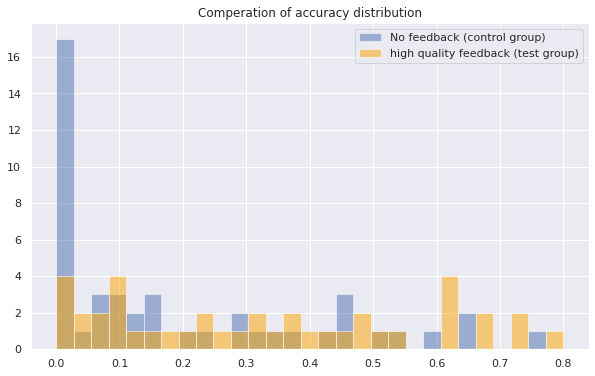

In [70]:
plot_accuracy_distribution(control_group, test_group, test_group_name)

### 1.4.2. Histogram

In [77]:
_df = df_user_error.copy()
_df.loc[_df['user__feedback'] == False, 'test_group'] = "control group"

<AxesSubplot:title={'center':'Distribution of f1 metric between test groups'}, xlabel='test_group', ylabel='f1'>

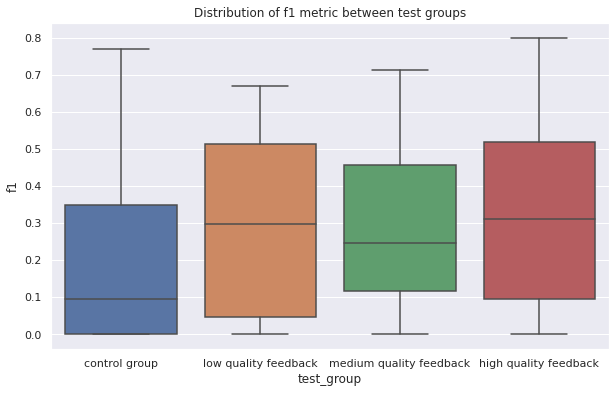

In [80]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of f1 metric between test groups")
sns.boxplot(x='test_group', y='f1', data=_df, order=["control group"] + TEST_GROUP_NAMES)

# 2. Confidence intervals
## 2.1. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [74]:
data = []

for metric in METRICS:
    
    control_group = df_user_error[
        (df_user_error['test_group'] == "high quality feedback") &
        (df_user_error['user__feedback'] == False)
    ][metric]
    
    for test_group_name in TEST_GROUP_NAMES:
        test_group = df_user_error[
            (df_user_error['test_group'] == test_group_name) &
            (df_user_error['user__feedback'] == True)
        ][metric]
        mean, lower_bound, upper_bound = get_confidence_intervals(test_group, control_group)

        data.append({
            "test_group_name": test_group_name,
            "metric": metric,
            "lower_bound": lower_bound,
            "mean": mean,
            "upper_bound": upper_bound
        })

pd.DataFrame(data)

,test_group_name,metric,lower_bound,mean,upper_bound
0,low quality feedback,f1,-31.252275,58.781865,116.765712
1,medium quality feedback,f1,-31.735451,48.351489,98.737009
2,high quality feedback,f1,-19.106744,70.899807,125.453096
3,low quality feedback,precision,-27.561531,62.481706,118.728272
4,medium quality feedback,precision,-20.287318,66.631626,121.620651
5,high quality feedback,precision,-7.001596,86.414101,143.197732
6,low quality feedback,recall,-43.595038,47.708905,103.111570
7,medium quality feedback,recall,-39.493753,38.486277,86.062143
8,high quality feedback,recall,-27.130804,56.015627,107.099546
